# 0. Importing Necessary Packages

In [1]:
# Matplotlib backend
%matplotlib notebook

# Importing necessary modules
import time
import numpy as np
import glob, os, copy
from matplotlib import pyplot as plt
import pandas as pd
from astropy.io import fits
from astropy.stats import sigma_clipped_stats

current_dir = os.getcwd()    # Current working directory
login_file = "/data2/iraf/login.cl"    # Please give the absolute path of your 'login.cl' file

# Reading 'login.cl' file
f = open(login_file, "r")
ll = f.readlines()
f.close()

# Finding the string for home directory in 'login.cl' file
line_homedir = np.argwhere(pd.Series(ll).str.startswith("set\thome\t\t=").values)[0][0]
idx_start = ll[line_homedir].find('"')
idx_end = ll[line_homedir].find('"', idx_start+1)
dir_iraf = ll[line_homedir][idx_start+1:idx_end]    # Home directory recoded in the 'login.cl' file
print(dir_iraf)    # For check

# Importing IRAF
os.chdir(dir_iraf)
from pyraf import iraf
os.chdir(current_dir)

/data2/iraf/


# 1. Displaying the Images

### 1) Image names

In [2]:
dir_img = "/data2/CLASS/astronomicalobservation/Combined_images/"
imglist = [dir_img+"NGC2775-g.fits", dir_img+"NGC2775-i.fits"]
n_img = len(imglist)
imglist

['/data2/CLASS/astronomicalobservation/Combined_images/NGC2775-g.fits',
 '/data2/CLASS/astronomicalobservation/Combined_images/NGC2775-i.fits']

### 2) Running DS9

In [3]:
# You can also run this command in terminal.
ds9_options = "-scalemode zscale -scale lock yes -frame lock image "
names = ""
for i in np.arange(n_img):
    names += imglist[i]+" "
ds9_command = "ds9 "+ds9_options+names+"&"
print('Running "'+ds9_command+'" in the terminal...')
os.system(ds9_command)

Running "ds9 -scalemode zscale -scale lock yes -frame lock image /data2/CLASS/astronomicalobservation/Combined_images/NGC2775-g.fits /data2/CLASS/astronomicalobservation/Combined_images/NGC2775-i.fits &" in the terminal...


0

# 2. Running IRAF/Ellipse Task 

### 1) Importing IRAF/Ellipse Task

In [4]:
# IRAF/ellipse task is in the STSDAS package (IRAF external package)
iraf.stsdas()
iraf.stsdas.analysis()
iraf.stsdas.analysis.isophote()



      +------------------------------------------------------------+
      |       Space Telescope Science Data Analysis System         |
      |                   STSDAS Version 3.18.3                    |
      |                                                            |
      |   Space Telescope Science Institute, Baltimore, Maryland   |
      |   Copyright (C) 2014 Association of Universities for       |
      |            Research in Astronomy, Inc.(AURA)               |
      |       See stsdas$copyright.stsdas for terms of use.        |
      |         For help, send e-mail to help@stsci.edu            |
      |                                                            |
      +------------------------------------------------------------+


### 2) Parameter Information of IRAF/Ellipse Task

In [5]:
# For viewing help file of "ellipse" task
### IRAF.net website has recently stop its service... :(
### But you can still see the detailed description of input parameters of any tasks (but not so convenient) 
iraf.epar("ellipse")
# You have to see the detailed definition of each parameter in geompar, controlpar, samplepar, and magpar.
# iraf.epar("[TASK_NAME]")
### Click "[TASK_NAME] help" for viewing the parameter editor help browser

### 3) Declaration of Function (for convenience!)

In [6]:
def fit_ellipse(input_image, output_table=None, interactive=False,
                model_image=None, residual_image=None, display=False, data_file=None,
                x0=100.0, y0=100.0, ellip0=0.1, pa0=45.0, sma0=10.0,  # geompar
                minsma=0.0, maxsma=50.0, step=1.0, linear=False, recenter=True,  # geompar
                minit=10, maxit=100, hcenter=False, hellip=False, hpa=False,  # controlpar
                usclip=3.0, lsclip=3.0, nclip=0,  # samplepar
                mag0=25.0, refer=1.0, zerolevel=0.0,  # magpar
                backgr=0.0, interp='linear'):  # bmodel

    '''
    # --- basic input parameters --- #
    input_image - input image name ('[FILENAME].fits')
    output_table - output table name (default: '[FILENAME].tab')
    interactive - interactive (boolean, default: False)
    model_image - output model image (default: '[FILENAME]_mod.fits')
    residual_image - output residual image (default: '[FILENAME]_res.fits')
    data_file - output data file (default: '[FILENAME].dat')
    display - display the results or not? (boolean, default: False)
    
    # --- geompar set --- #
    x0, y0 - initial isophote center X, Y [pixel]
    ellip0, pa0 - initial ellipticity, position angle [degree]
    sma0 - initial semi-major axis (SMA) length [pixel]
    minsma - minimum SMA length for fitting [pixel] (default: 0.0)
    maxsma - maximum SMA length for fitting [pixel]
    step - SMA step between successive ellipses [pixel OR relative value]
    linear - linear SMA step for fitting? (boolean, default: False)
    recenter - do you allow to re-center x0 & y0? (boolean, default: False)
    
    # --- controlpar set --- #
    minit - minimum iteration number at each step of SMA (default: 10)
    maxit - maximum iteration number at each step of SMA (default: 100)
    hcenter - do you want to hold center fixed? (boolean, default: False)
    hellip - do you want to hold ellipticity fixed? (boolean, default: False)
    hpa - do you want to hold position angle fixed? (boolean, default: False)
    
    # --- samplepar set --- #
    usclip - upper sigma-clip criterion (default: 3)
    lsclip - lower sigma-clip criterion (default: 3)
    nclip - iteration number for the sigma clipping (default: 0)
    
    # --- magpar set --- #
    mag0 - magnitude zeropoint for sky brightness (default: 25.0)
    refer - reference count for sky brightness (default: 1.0)
    zerolevel - bias level (default: 0.0)    
    ### mag = mag0-2.5*log10((intensity-zerolevel)/refer)
    
    # --- bmodel parameter set --- #
    backgr - background level for making model image (default: 0.0)
    interp - interpolation algorithm for model image ('nearest' OR 'linear' OR 'poly3' OR 'spline', default: 'linear')    
    '''
    
    iname = input_image.split('.fits')[0].split('/')[-1]    # Image name
    if (output_table is None):
        output_table = iname+'.tab'    # Output table name
    if (model_image is None):
        model_image = iname+'_mod.fits'    # Output model image name
    if (residual_image is None):
        residual_image = iname+'_res.fits'    # Output residual image name
    if (data_file is None):
        data_file = iname+'.dat'    # Output data file name 

    # Running IRAF/ellipse task
    os.system("rm -rfv "+output_table+" colnames.lis "+data_file)  # Reset by removing the output data
    kwargs = {"x0":x0, "y0":y0, "ellip0":ellip0, "pa0":pa0, "sma0":sma0,
              "minsma":minsma, "maxsma":maxsma, "step":step, "linear":linear, "recenter":recenter,
              "minit":minit, "maxit":maxit, "hcenter":hcenter, "hellip":hellip, "hpa":hpa,
              "integrmode":"bi-linear", "usclip":usclip, "lsclip":lsclip, "nclip":nclip,
              "mag0":mag0, "refer":refer, "zerolevel":zerolevel}
    iraf.ellipse(input=input_image, output=output_table, interactive=interactive,
                 **kwargs)
    
    # Making model, residual images
    os.system("rm -rfv "+model_image+" "+residual_image)  # Reset by removing the output images
    iraf.bmodel(table=output_table, output=model_image, parent=input_image,
                backgr=backgr, interp=interp)    # bmodel task for model image
    
    iraf.imarith(input_image, "-", model_image, residual_image)    # input - model = residual
    
    if display:    # if display == True, DS9 will display input, model, and residual images.
        opt = " -scalemode zscale -scale lock yes -frame lock image "
        opt += " -tile grid mode manual -tile grid layout 3 1 "
        os.system("ds9 "+opt+input_image+" "+model_image+" "+residual_image+"&")
    
    # Reading output results
    ### output_table is not directly readable because it is a binary-format file :( 
    iraf.tlcol(output_table, nlist=1, Stdout='colnames.lis')    # Extracting column names
    iraf.tdump(table=output_table, columns="@colnames.lis", datafile=data_file)    # Making ASCII data file
    
    f = open("colnames.lis", "r")
    cc = f.readlines()
    f.close()

    colnames = []
    for line in cc:
        if not (line[0] == '#'):
            colnames.append(line.split(' ')[0])
#     print(colnames)    # column names array
    
    iso_tbl = np.genfromtxt(data_file, encoding="ascii", names=colnames)    # Reading data
    iso_df = pd.DataFrame(iso_tbl)
#     print(iso_df)    # output result data frame
    
    return iso_df

### 4) Sky Estimation (depending on your image)

In [7]:
# ----- SDSS pixel scale & Magnitude zeropoint ----- #
pixel_scale = 0.396    # arcsec/pixel (SDSS image)
mag0_g = 22.5   # SDSS g-magnitude zeropoint for sky brightness (just for example)
# mag0_g = 21.84 + 2.5*np.log10(pixel_scale**(-2))  # mag/arcsec^2 --> mag/pixel^2
mag0_i = 22.5    # SDSS i-magnitude zeropoint for sky brightness (just for example)
# mag0_i = 20.16 + 2.5*np.log10(pixel_scale**(-2))  # mag/arcsec^2 --> mag/pixel^2
### You should revise these depending on your images! (Maybe) the above magnitude zeropoint is not so accurate... 
### https://www.sdss.org/dr14/imaging/other_info/

#### For magnitude zeropoint, please use the given value on the website below.

* **SDSS: [SDSS Imaging Information](https://www.sdss.org/dr14/imaging/other_info/)**
* **HST: [HST ACS Zeropoint](https://www.stsci.edu/hst/instrumentation/acs/data-analysis/zeropoints)**

#### Or you can also measure the zeropoint by yourself using (secondary) calibration in your image.

#### Pixel scale is for tranforming the unit of surface brightness from ${\rm mag/pixel^2}$ to ${\rm mag/arcsec^2}$ (or the opposite).

#### If you just want to use ${\rm mag/pixel^2}$ unit, you do not have to use pixel scale of the images.

#### However, ${\rm mag/arcsec^2}$ unit is generally used for surface photometry.

In [8]:
# For g-band image of M105
imgname = "/data2/CLASS/astronomicalobservation/Combined_images/NGC2775-g.fits"
x_center, y_center = 450.0, 453.0    # depending on your object & image size
r0 = 400.0    # outer boundary for sky estimation (up to you)

# --- Background estimation for determining backgroun level --- #
### (This is up to you! You do not have to do this if the background level in your images can be obviously determined.)
img = fits.getdata(imgname, ext=0)

x1d = np.arange(0, img.shape[1], 1)
y1d = np.arange(0, img.shape[0], 1)
xx, yy = np.meshgrid(x1d, y1d, sparse=True)
z = ((xx-x_center)**2.0 + (yy-y_center)**2.0 - r0**2.0)
sky_region = (z > 0.0)

avg, med, std = sigma_clipped_stats(img[sky_region], sigma=3.0)
sky_val, sky_sig = 3.0*med - 2.0*avg, std
print("Image: "+imgname)
print("sky level: {0:.4f}".format(sky_val))
print("sky sigma: {0:.4f}".format(sky_sig))
# ---------- #

Image: /data2/CLASS/astronomicalobservation/Combined_images/NGC2775-g.fits
sky level: 0.0115
sky sigma: 0.0155


<IPython.core.display.Javascript object>


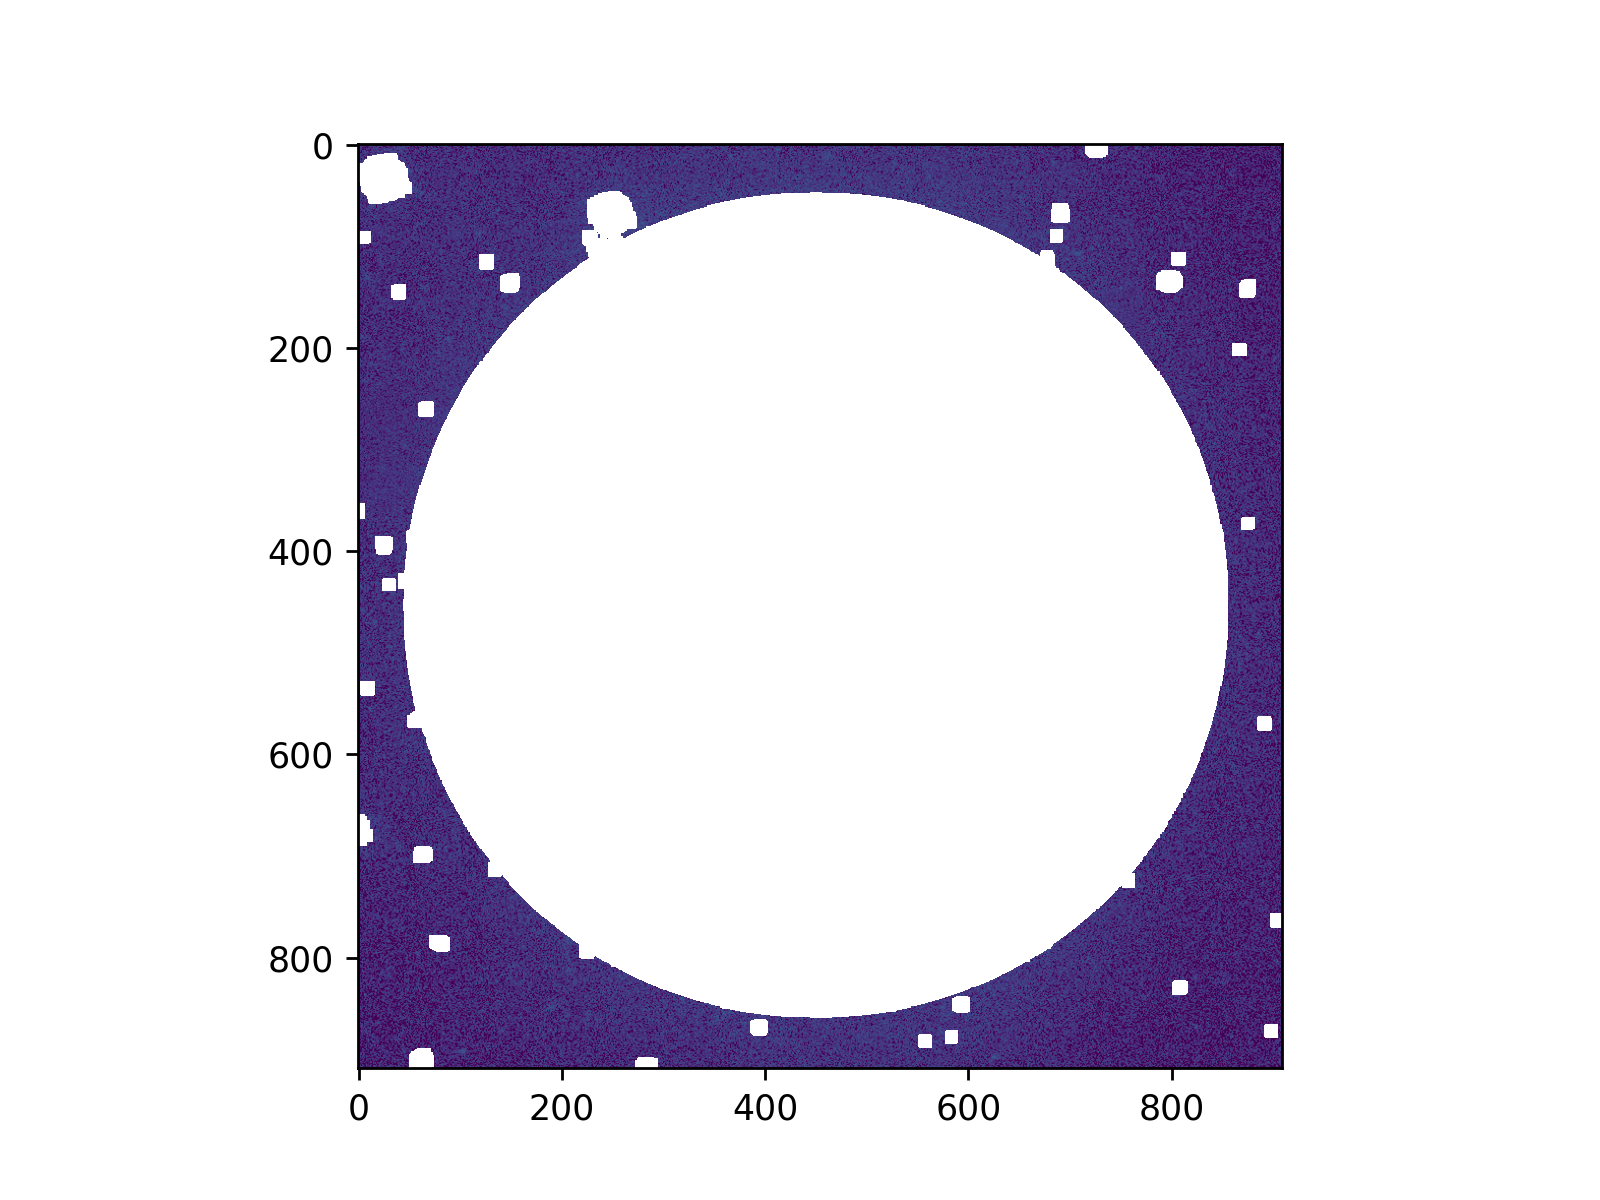

In [9]:

from photutils.segmentation import make_source_mask
from astropy.visualization import simple_norm
data_m1 =np.ma.array(img, mask = ~sky_region)
sourcemask = make_source_mask(data_m1, nsigma = 3, npixels = 3, dilate_size= 11)
data_m2 = np.ma.array(data_m1, mask = sourcemask)
norm = simple_norm(data_m2[sky_region], 'log')
plt.figure()
plt.imshow(data_m2*10, norm = norm )
sky_val, sky_sig = np.median(data_m2.data[~data_m2.mask]), np.std(data_m2.data[~data_m2.mask])

### 5) Running IRAF/Ellipse Task & Showing the Results

In [10]:

depth_g = -2.5*np.log10(5*sky_sig*np.sqrt(np.pi*(1.44/0.396)**2))+22.5

In [41]:
sky_val_g = sky_val    # sky brightness (unit: pixel count)
rmax = 500.0    # maximum SMA (up to you)
kwargs = {"x0":x_center, "y0":y_center, "ellip0":0.3, "sma0":5.0,
          "minsma":0.05, "maxsma":rmax, "step":0.08,
          "hcenter":False, "hellip":False, "hpa":False,
          "nclip":3, "mag0":mag0_g, "refer":sky_val_g,    # https://www.sdss.org/dr12/algorithms/magnitudes/
          "backgr":sky_val_g, "interp":"linear"}  # Here you can change input (default) parameter if needed!
iso_df_g = fit_ellipse(imgname, display=True, **kwargs)

# def fit_ellipse(input_image, output_table=None, interactive=False,
#                 model_image=None, residual_image=None, display=False, data_file=None,
#                 x0=100.0, y0=100.0, ellip0=0.1, pa0=45.0, sma0=10.0,  # geompar
#                 minsma=0.0, maxsma=50.0, step=1.0, linear=False, recenter=False,  # geompar
#                 minit=10, maxit=100, hcenter=False, hellip=False, hpa=False,  # controlpar
#                 usclip=3.0, lsclip=3.0, nclip=0,  # samplepar
#                 mag0=25.0, refer=1.0, zerolevel=0.0,  # magpar
#                 backgr=0.0, interp='linear'):  # bmodel

removed 'NGC2775-i.tab'
removed 'colnames.lis'
removed 'NGC2775-i.dat'
Running object locator... Done.
#
# Semi-    Isophote      Ellipticity     Position   Grad.  Data Flag Iter. Stop
# major      mean                         Angle      rel.                  code
# axis     intensity                                error
#(pixel)                                 (degree)
#
   5.00    38.78(  0.23) 0.086(0.003) -23.42( 1.18) 0.016   30   0    20    0
   5.40    36.03(  0.23) 0.091(0.003) -21.69( 1.12) 0.016   33   0    10    0
   5.83    33.39(  0.16) 0.092(0.002) -22.87( 0.80) 0.013   35   0    10    0
   6.30    31.03(  0.17) 0.096(0.003) -24.34( 0.82) 0.012   38   0    10    0
   6.80    28.79(  0.12) 0.100(0.002) -24.38( 0.59) 0.010   40   1    10    0
   7.35    26.71(  0.12) 0.103(0.002) -24.38( 0.57) 0.011   44   0    10    0
   7.93    24.73(  0.14) 0.106(0.002) -24.07( 0.67) 0.013   47   0    10    0
   8.57    22.92(  0.14) 0.110(0.002) -24.24( 0.69) 0.013   51   0    10    0
 

IMAGE    t /data2/CLASS/astronomicalobservation/Combined_images/NGC2775-i.fits


In [12]:
# Columns in the result array
iso_df_g.columns

Index(['SMA', 'INTENS', 'INT_ERR', 'PIX_VAR', 'RMS', 'ELLIP', 'ELLIP_ERR',
       'PA', 'PA_ERR', 'X0', 'X0_ERR', 'Y0', 'Y0_ERR', 'GRAD', 'GRAD_ERR',
       'GRAD_R_ERR', 'RSMA', 'MAG', 'MAG_LERR', 'MAG_UERR', 'TFLUX_E',
       'TFLUX_C', 'TMAG_E', 'TMAG_C', 'NPIX_E', 'NPIX_C', 'A3', 'A3_ERR', 'B3',
       'B3_ERR', 'A4', 'A4_ERR', 'B4', 'B4_ERR', 'NDATA', 'NFLAG', 'NITER',
       'STOP', 'A_BIG', 'SAREA'],
      dtype='object')

In [13]:
# Some useful information in the results
iso_df_g[["SMA","INTENS","X0","Y0","MAG","MAG_LERR","MAG_UERR","ELLIP","PA","A4","B4"]].head(10)

SMA    INTENS        X0        Y0       MAG  MAG_LERR  MAG_UERR  \
0  0.000000  37.33312  449.9781  454.8299  13.70585       NaN       NaN   
1  0.536637  35.23296  449.9781  454.8299  13.76871  0.001742  0.001739   
2  0.579568  35.07084  449.9763  454.8160  13.77372  0.001871  0.001867   
3  0.625934  34.89688  449.9743  454.8009  13.77912  0.002007  0.002003   
4  0.676008  34.70995  449.9722  454.7845  13.78495  0.002152  0.002148   
5  0.730089  34.50938  449.9699  454.7669  13.79124  0.002306  0.002301   
6  0.788496  34.23840  449.9686  454.7530  13.79980  0.002328  0.002323   
7  0.851576  33.84330  449.9669  454.7499  13.81240  0.002254  0.002249   
8  0.919702  33.35404  449.9608  454.7570  13.82822  0.002407  0.002402   
9  0.993278  32.81184  449.9494  454.7576  13.84601  0.002513  0.002508   

      ELLIP        PA        A4        B4  
0       NaN       NaN       NaN       NaN  
1  0.230210 -0.787924  0.000510  0.066114  
2  0.230785 -0.797711  0.000335  0.065181  
3  0.231442 -0.797711  0.000080  0.064162  
4  0.232099 -0.810798 -0.000111  0.063065  
5  0.232797 -0.810798 -0.000326  0.059328  
6  0.214324 -0.860269  0.004520  0.051358  
7  0.164627 -1.931598  0.014074  0.044340  
8  0.097999 -4.844940  0.018382  0.043711  
9  0.031132 -9.468144  0.017139  0.025907

Image: /data2/CLASS/astronomicalobservation/Combined_images/NGC2775-r.fits
sky level: 0.0235
sky sigma: 0.0302


<IPython.core.display.Javascript object>


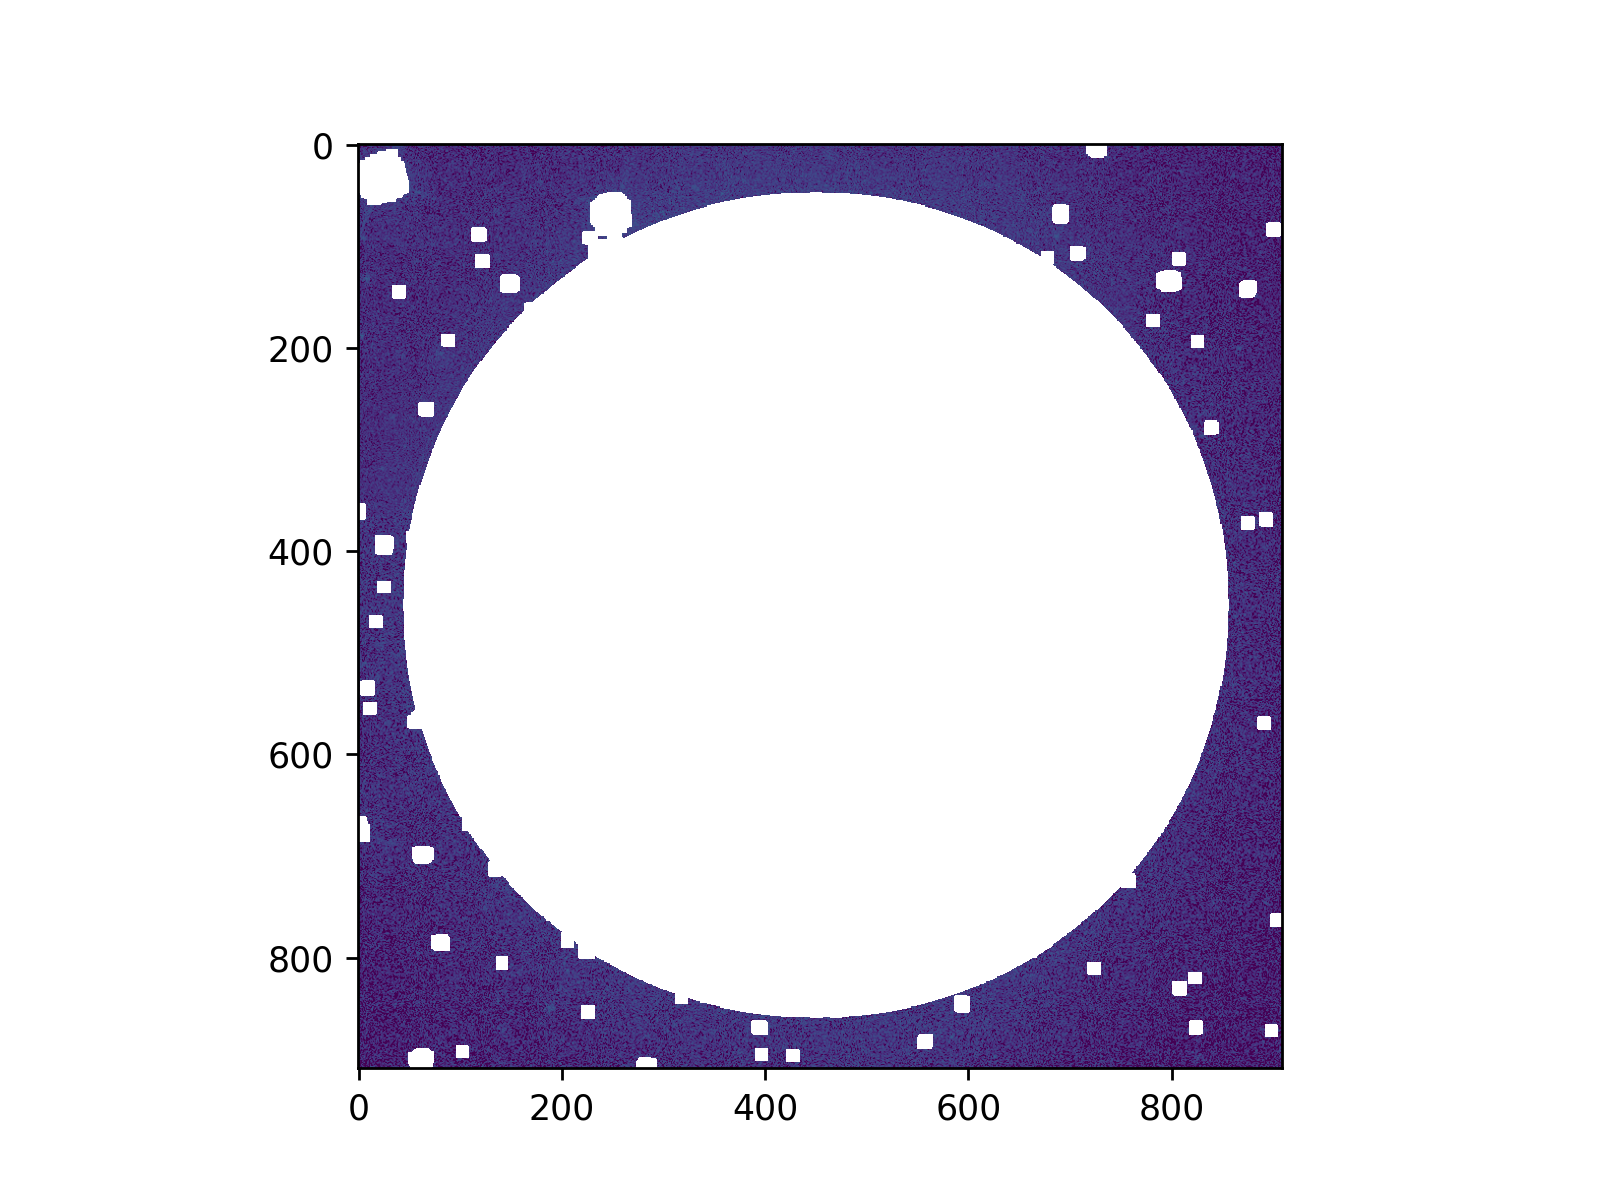

removed 'NGC2775-r.tab'
removed 'colnames.lis'
removed 'NGC2775-r.dat'
Running object locator... Done.
#
# Semi-    Isophote      Ellipticity     Position   Grad.  Data Flag Iter. Stop
# major      mean                         Angle      rel.                  code
# axis     intensity                                error
#(pixel)                                 (degree)
#
   5.00    26.57(  0.16) 0.085(0.003) -22.90( 1.20) 0.017   30   0    20    0
   5.40    24.72(  0.15) 0.092(0.003) -21.22( 1.06) 0.015   33   0    10    0
   5.83    22.92(  0.12) 0.094(0.003) -22.18( 0.85) 0.014   35   0    10    0
   6.30    21.28(  0.13) 0.097(0.003) -22.78( 0.92) 0.014   38   0    10    0
   6.80    19.70(  0.12) 0.098(0.003) -23.27( 0.83) 0.014   41   0    10    0
   7.35    18.25(  0.11) 0.101(0.003) -23.38( 0.76) 0.014   44   0    10    0
   7.93    16.90(  0.10) 0.105(0.003) -23.17( 0.74) 0.016   47   0    10    0
   8.57    15.67(  0.12) 0.110(0.003) -23.54( 0.85) 0.016   51   0    10    0
 

IMAGE    t /data2/CLASS/astronomicalobservation/Combined_images/NGC2775-r.fits


In [14]:
# For g-band image of M105
mag0_r = 22.5
imgname = "/data2/CLASS/astronomicalobservation/Combined_images/NGC2775-r.fits"
x_center, y_center = 450.0, 453.0    # depending on your object & image size
r0 = 400.0    # outer boundary for sky estimation (up to you)

# --- Background estimation for determining backgroun level --- #
### (This is up to you! You do not have to do this if the background level in your images can be obviously determined.)
img = fits.getdata(imgname, ext=0)

x1d = np.arange(0, img.shape[1], 1)
y1d = np.arange(0, img.shape[0], 1)
xx, yy = np.meshgrid(x1d, y1d, sparse=True)
z = ((xx-x_center)**2.0 + (yy-y_center)**2.0 - r0**2.0)
sky_region = (z > 0.0)

avg, med, std = sigma_clipped_stats(img[sky_region], sigma=3.0)
sky_val, sky_sig = 3.0*med - 2.0*avg, std
print("Image: "+imgname)
print("sky level: {0:.4f}".format(sky_val))
print("sky sigma: {0:.4f}".format(sky_sig))
# ---------- #
from photutils.segmentation import make_source_mask
from astropy.visualization import simple_norm
data_m1 =np.ma.array(img, mask = ~sky_region)
sourcemask = make_source_mask(data_m1, nsigma = 3, npixels = 3, dilate_size= 11)
data_m2 = np.ma.array(data_m1, mask = sourcemask)
norm = simple_norm(data_m2[sky_region], 'log')
plt.figure()
plt.imshow(data_m2*10, norm = norm )
sky_val, sky_sig = np.median(data_m2.data[~data_m2.mask]), np.std(data_m2.data[~data_m2.mask])
depth_r = -2.5*np.log10(5*sky_sig*np.sqrt(np.pi*(1.44/0.396)**2))+22.5
sky_val_r = sky_val    # sky brightness (unit: pixel count)
rmax = 500.0    # maximum SMA (up to you)
kwargs = {"x0":x_center, "y0":y_center, "ellip0":0.3, "sma0":5.0,
          "minsma":0.05, "maxsma":rmax, "step":0.08,
          "hcenter":False, "hellip":False, "hpa":False,
          "nclip":3, "mag0":mag0_r, "refer":sky_val_r,    # https://www.sdss.org/dr12/algorithms/magnitudes/
          "backgr":sky_val_r, "interp":"linear"}  # Here you can change input (default) parameter if needed!
iso_df_r = fit_ellipse(imgname, display=True, **kwargs)

# def fit_ellipse(input_image, output_table=None, interactive=False,
#                 model_image=None, residual_image=None, display=False, data_file=None,
#                 x0=100.0, y0=100.0, ellip0=0.1, pa0=45.0, sma0=10.0,  # geompar
#                 minsma=0.0, maxsma=50.0, step=1.0, linear=False, recenter=False,  # geompar
#                 minit=10, maxit=100, hcenter=False, hellip=False, hpa=False,  # controlpar
#                 usclip=3.0, lsclip=3.0, nclip=0,  # samplepar
#                 mag0=25.0, refer=1.0, zerolevel=0.0,  # magpar
#                 backgr=0.0, interp='linear'):  # bmodel

totmag_r = -2.5*np.log10(np.sum(iso_df_r['INTENS'] * iso_df_r['NDATA'])) + 22.5
iso_df_r['MAG'] = -2.5*np.log10(iso_df_r['INTENS']) + 22.5

# 3. Surface Photometry Example #1 (Elliptical, M105)

### 1) $i$-band ($g$-band for M105 has already been done above!)

In [15]:
# -------------------------- #
# ----- Sky Estimation ----- #
# -------------------------- #
# For i-band image of M105
imgname = "/data2/CLASS/astronomicalobservation/Combined_images/NGC2775-i.fits"
x_center, y_center = 450, 453   # depending on your object & image size
r0 = 400    # outer boundary for sky estimation (up to you)

# --- Background estimation for determining backgroun level --- #
### (This is up to you! You do not have to do this if the background level in your images can be obviously determined.)
img = fits.getdata(imgname, ext=0)

x1d = np.arange(0, img.shape[1], 1)
y1d = np.arange(0, img.shape[0], 1)
xx, yy = np.meshgrid(x1d, y1d, sparse=True)
z = ((xx-x_center)**2.0 + (yy-y_center)**2.0 - r0**2.0)
sky_region = (z > 0.0)

avg, med, std = sigma_clipped_stats(img[sky_region], sigma=3.0)
sky_val, sky_sig = np.abs(3.0*med - 2.0*avg), std
print("Image: "+imgname)
print("sky level: {0:.4f}".format(sky_val))
print("sky sigma: {0:.4f}".format(sky_sig))

Image: /data2/CLASS/astronomicalobservation/Combined_images/NGC2775-i.fits
sky level: 0.0370
sky sigma: 0.0518


<IPython.core.display.Javascript object>


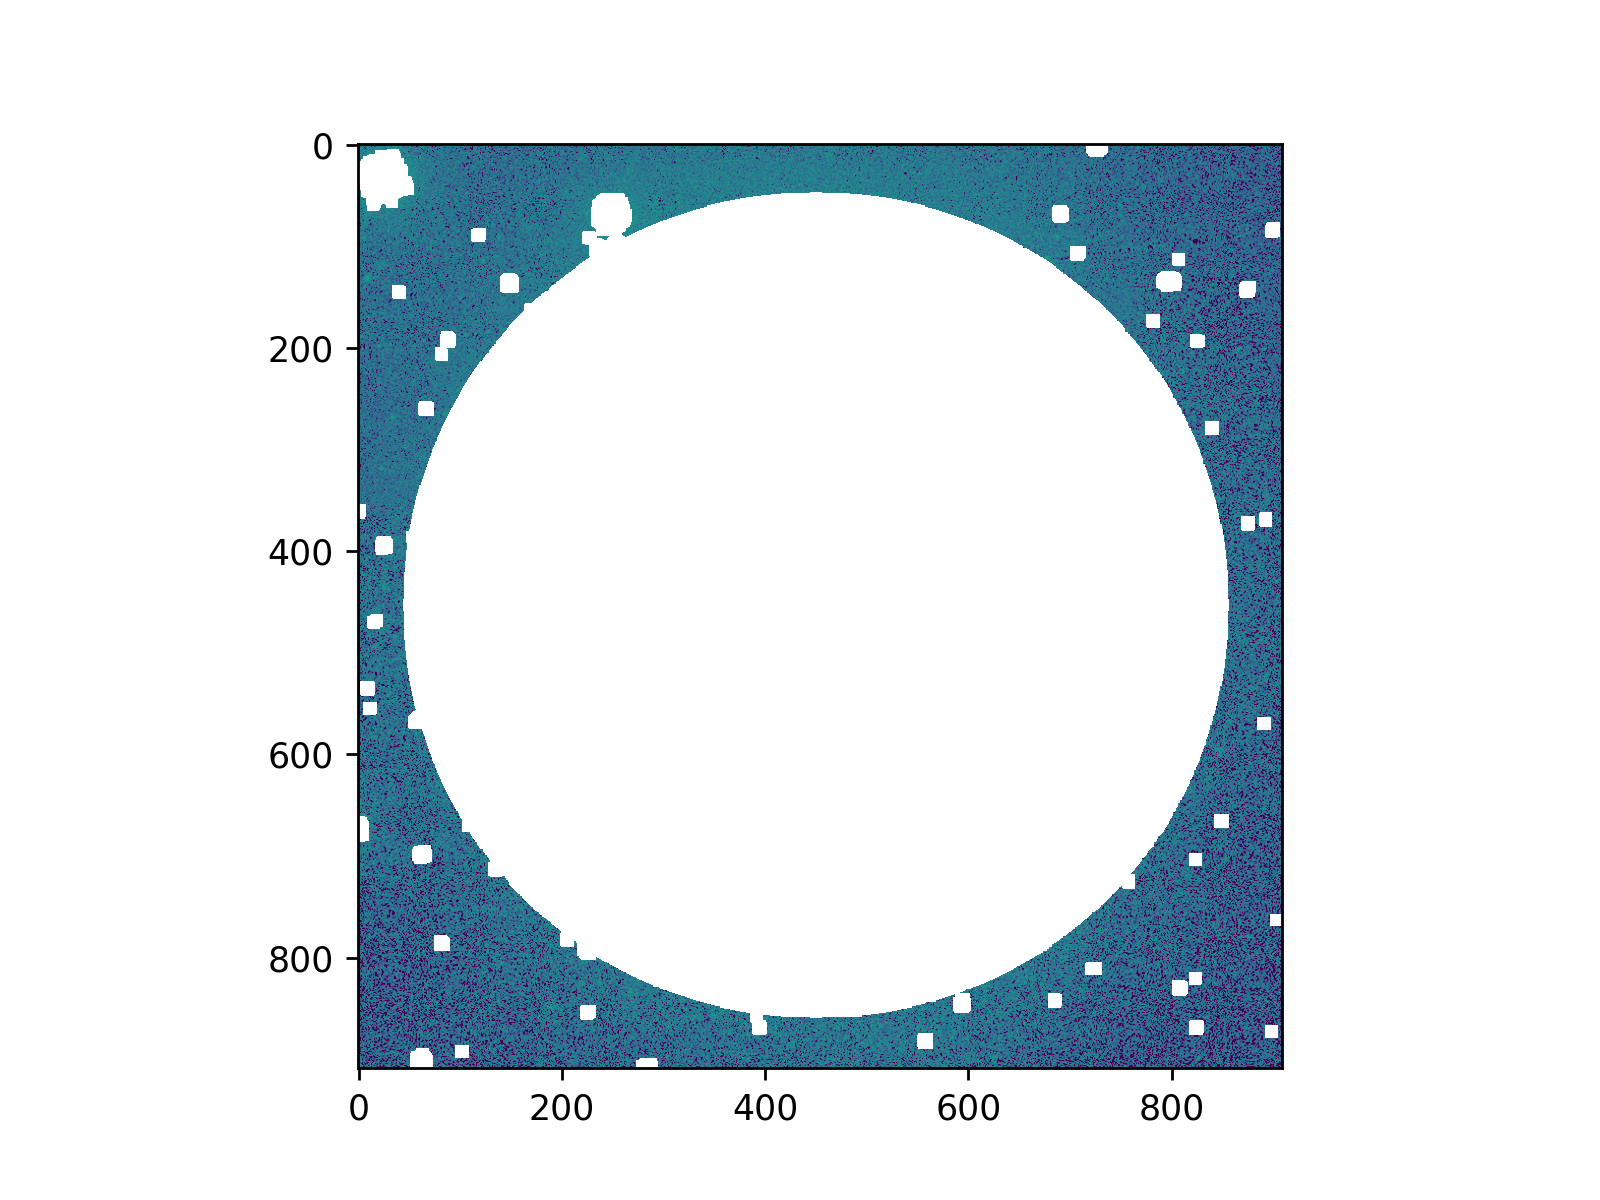

In [16]:
from photutils.segmentation import make_source_mask
from astropy.visualization import simple_norm
data_m1 =np.ma.array(img, mask = ~sky_region)
sourcemask = make_source_mask(data_m1, nsigma = 3, npixels = 3, dilate_size= 11)
data_m2 = np.ma.array(data_m1, mask = sourcemask)
norm = simple_norm(data_m2[sky_region], 'log')
plt.figure()
plt.imshow(data_m2*10, norm = norm )
sky_val, sky_sig = np.median(data_m2.data[~data_m2.mask]), np.std(data_m2.data[~data_m2.mask])

In [17]:
depth_i = -2.5*np.log10(5*sky_sig*np.sqrt(np.pi*(1.26/0.396)**2))+22.5

In [18]:

# ---------- #

# -------------------------------- #
# ----- Running IRAF/Ellipse ----- #
# -------------------------------- #
sky_val_i = sky_val    # sky brightness (unit: pixel count)
rmax = 800.0    # maximum SMA (up to you)
kwargs = {"x0":x_center, "y0":y_center, "ellip0":0.3, "sma0":5.0,
          "minsma":0.05, "maxsma":rmax, "step":0.08,
          "hcenter":False, "hellip":False, "hpa":False,
          "nclip":3, "mag0":mag0_i, "refer":sky_val_i,    # https://www.sdss.org/dr12/algorithms/magnitudes/
          "backgr":sky_val_i, "interp":"linear"}  # Here you can change input (default) parameter if needed!
iso_df_i = fit_ellipse(imgname, display=True, **kwargs)

removed 'NGC2775-i.tab'
removed 'colnames.lis'
removed 'NGC2775-i.dat'
Running object locator... Done.
#
# Semi-    Isophote      Ellipticity     Position   Grad.  Data Flag Iter. Stop
# major      mean                         Angle      rel.                  code
# axis     intensity                                error
#(pixel)                                 (degree)
#
   5.00    38.78(  0.23) 0.086(0.003) -23.42( 1.18) 0.016   30   0    20    0
   5.40    36.03(  0.23) 0.091(0.003) -21.69( 1.12) 0.016   33   0    10    0
   5.83    33.39(  0.16) 0.092(0.002) -22.87( 0.80) 0.013   35   0    10    0
   6.30    31.03(  0.17) 0.096(0.003) -24.34( 0.82) 0.012   38   0    10    0
   6.80    28.79(  0.12) 0.100(0.002) -24.38( 0.59) 0.010   40   1    10    0
   7.35    26.71(  0.12) 0.103(0.002) -24.38( 0.57) 0.011   44   0    10    0
   7.93    24.73(  0.14) 0.106(0.002) -24.07( 0.67) 0.013   47   0    10    0
   8.57    22.92(  0.14) 0.110(0.002) -24.24( 0.69) 0.013   51   0    10    0
 

IMAGE    t /data2/CLASS/astronomicalobservation/Combined_images/NGC2775-i.fits


In [19]:
iso_df_g['MAG'] = -2.5*np.log10(iso_df_g['INTENS']) + 22.5
iso_df_i['MAG'] = -2.5*np.log10(iso_df_i['INTENS']) + 22.5

In [20]:
totmag_i = -2.5*np.log10(np.sum(iso_df_i['INTENS'] * iso_df_i['NDATA'])) + 22.5

In [21]:
totmag_g = -2.5*np.log10(np.sum(iso_df_g['INTENS'] * iso_df_g['NDATA'])) + 22.5


In [22]:
print(totmag_g, totmag_r, totmag_i)

11.412427756751205 10.573685688789524 10.153380923767259


In [23]:
print(depth_g, depth_r, depth_i)

23.244606142782178 22.524145956132962 22.079220940154148


In [24]:
totmag_g - totmag_r

0.8387420679616806

In [25]:
totmag_r - totmag_i

0.42030476502226577

### 2) Drawing the Radial Profile

In [26]:
iso_df_i = iso_df_i[:-2]

<IPython.core.display.Javascript object>


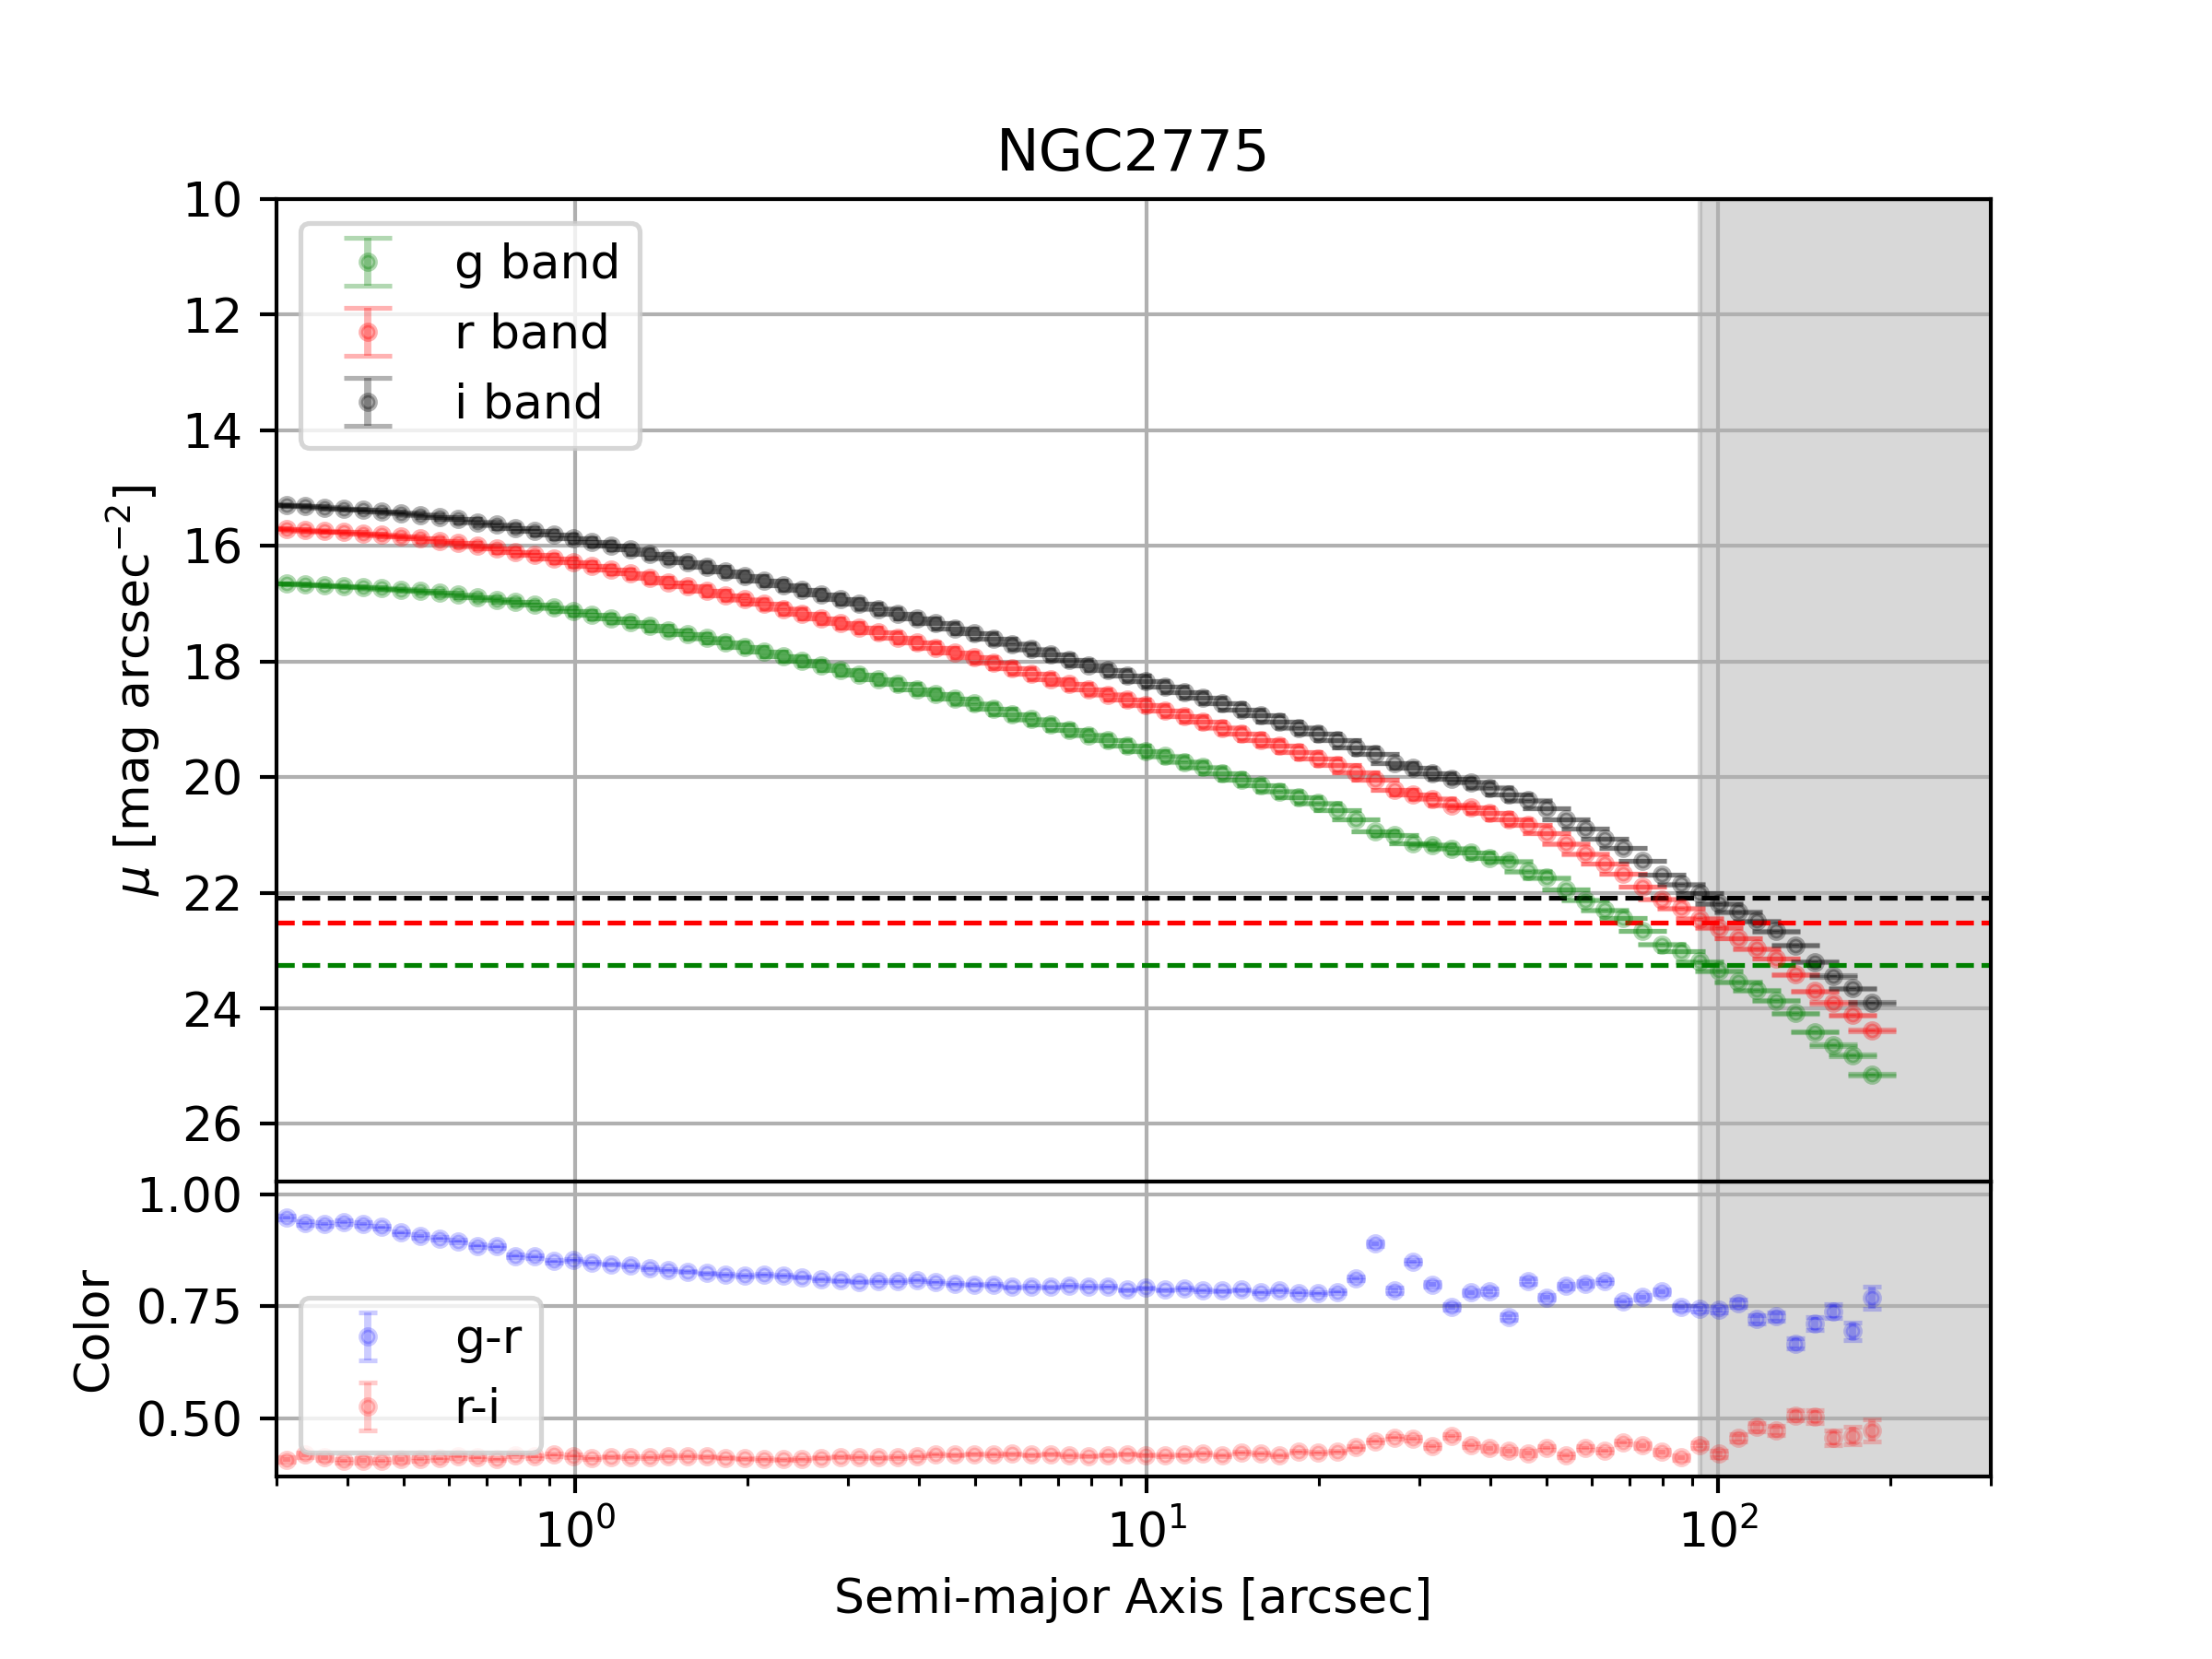

Text(0.5, 0, 'Semi-major Axis [arcsec]')

In [27]:
# Unit conversion
r_sma_g = iso_df_g['SMA'].values * pixel_scale    # pixel to arcsec
mu_g = iso_df_g['MAG'] - 2.5*np.log10(pixel_scale**(-2))    # mag/pixel^2 to mag/arcsec^2
e_mu_g = 2.5*iso_df_g['INT_ERR']/2.303/iso_df_g['INTENS']
r_sma_r = iso_df_r['SMA'].values * pixel_scale    # pixel to arcsec
mu_r = iso_df_r['MAG'] - 2.5*np.log10(pixel_scale**(-2))    # mag/pixel^2 to mag/arcsec^2
e_mu_r = 2.5*iso_df_r['INT_ERR']/2.303/iso_df_r['INTENS']
r_sma_i = iso_df_i['SMA'].values * pixel_scale    # pixel to arcsec
mu_i = iso_df_i['MAG'] - 2.5*np.log10(pixel_scale**(-2))    # mag/pixel^2 to mag/arcsec^2
e_mu_i = 2.5*iso_df_i['INT_ERR']/2.303/iso_df_i['INTENS']
### If you already set the mag0 in the unit of 'mag/arcsec^2',
### then you do not have to convert the unit from 'mag/pixel^2' to 'mag/arcsec^2'!

# Plotting
from matplotlib import gridspec
plt.figure(dpi = 150)

plt.xticks(visible=False)
plt.gca().invert_yaxis()
plt.subplots_adjust(hspace=0)
gs = gridspec.GridSpec(nrows = 2, ncols =1, height_ratios= [10, 3], width_ratios = [6])
ax0 = plt.subplot(gs[0])
ax0.set_title('NGC2775')
ax0.errorbar(r_sma_g, mu_g, yerr = e_mu_g, fmt = 'o', ms=3.0, c='g', capsize = 5, alpha=0.3, label = 'g band')#, linewidth=2.0, alpha=0.9)
ax0.errorbar(r_sma_r, mu_r, yerr = e_mu_r, fmt = 'o', ms=3.0, c='r', capsize = 5, alpha=0.3, label = 'r band')#, linewidth=2.0, alpha=0.9)
ax0.errorbar(r_sma_i, mu_i, yerr = e_mu_i, fmt = 'o', ms=3.0, c='k', capsize = 5, alpha=0.3, label = 'i band')#, linewidth=2.0, alpha=0.9)
ax0.axhline(depth_g, linestyle = '--', linewidth = 1, c = 'g')
ax0.axhline(depth_r, linestyle = '--', linewidth = 1, c = 'r')
ax0.axhline(depth_i, linestyle = '--', linewidth = 1, c = 'k')
cut = r_sma_g[np.argmin(np.abs(mu_g-depth_g))]
ax0.axvspan(cut, 800, color = 'gray', alpha = 0.3)
ax0.grid()
#ax.axhline(mag0_g - 2.5*np.log10(pixel_scale**(-2)), 0, 1,
#           linestyle='--', color='dodgerblue', linewidth=1.5, alpha=0.4)
#ax.axhline(mag0_i - 2.5*np.log10(pixel_scale**(-2)), 0, 1,
#           linestyle='--', color='magenta', linewidth=1.5, alpha=0.4)
#ax.axvline(1.5, 0, 1, linestyle='--', color='gray', linewidth=1.5, alpha=0.7)
ax0.set_xlim([0.3, 300])
ax0.set_xscale('log')
ax0.set_ylim([27, 10])
ax0.legend()

ax0.set_ylabel(r"$\mu$ [mag ${\rm arcsec^{-2}}$]")
ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.grid()
ax1.axvspan(cut, 800, color = 'gray', alpha = 0.3)
ax1.errorbar(r_sma_r, mu_g-mu_r, yerr = np.sqrt(e_mu_g**2+e_mu_r**2), fmt = 'o', ms=3.0, c='b', capsize = 2, alpha=0.2, label = 'g-r')#, linewidth=2.0, alpha=0.9)
ax1.errorbar(r_sma_r, mu_r-mu_i, yerr = np.sqrt(e_mu_r**2+e_mu_i**2), fmt = 'o', ms=3.0, c='r', capsize = 2, alpha=0.2, label = 'r-i')#, linewidth=2.0, alpha=0.9)
ax1.legend()
ax1.set_ylabel(r"Color")
ax1.set_xlabel("Semi-major Axis [arcsec]")

#ax1.plot(r_sma_g, mu_g-mu_i, 'x', ms = 3.0, color='black', alpha=0.6)
#plt.tight_layout()

<IPython.core.display.Javascript object>


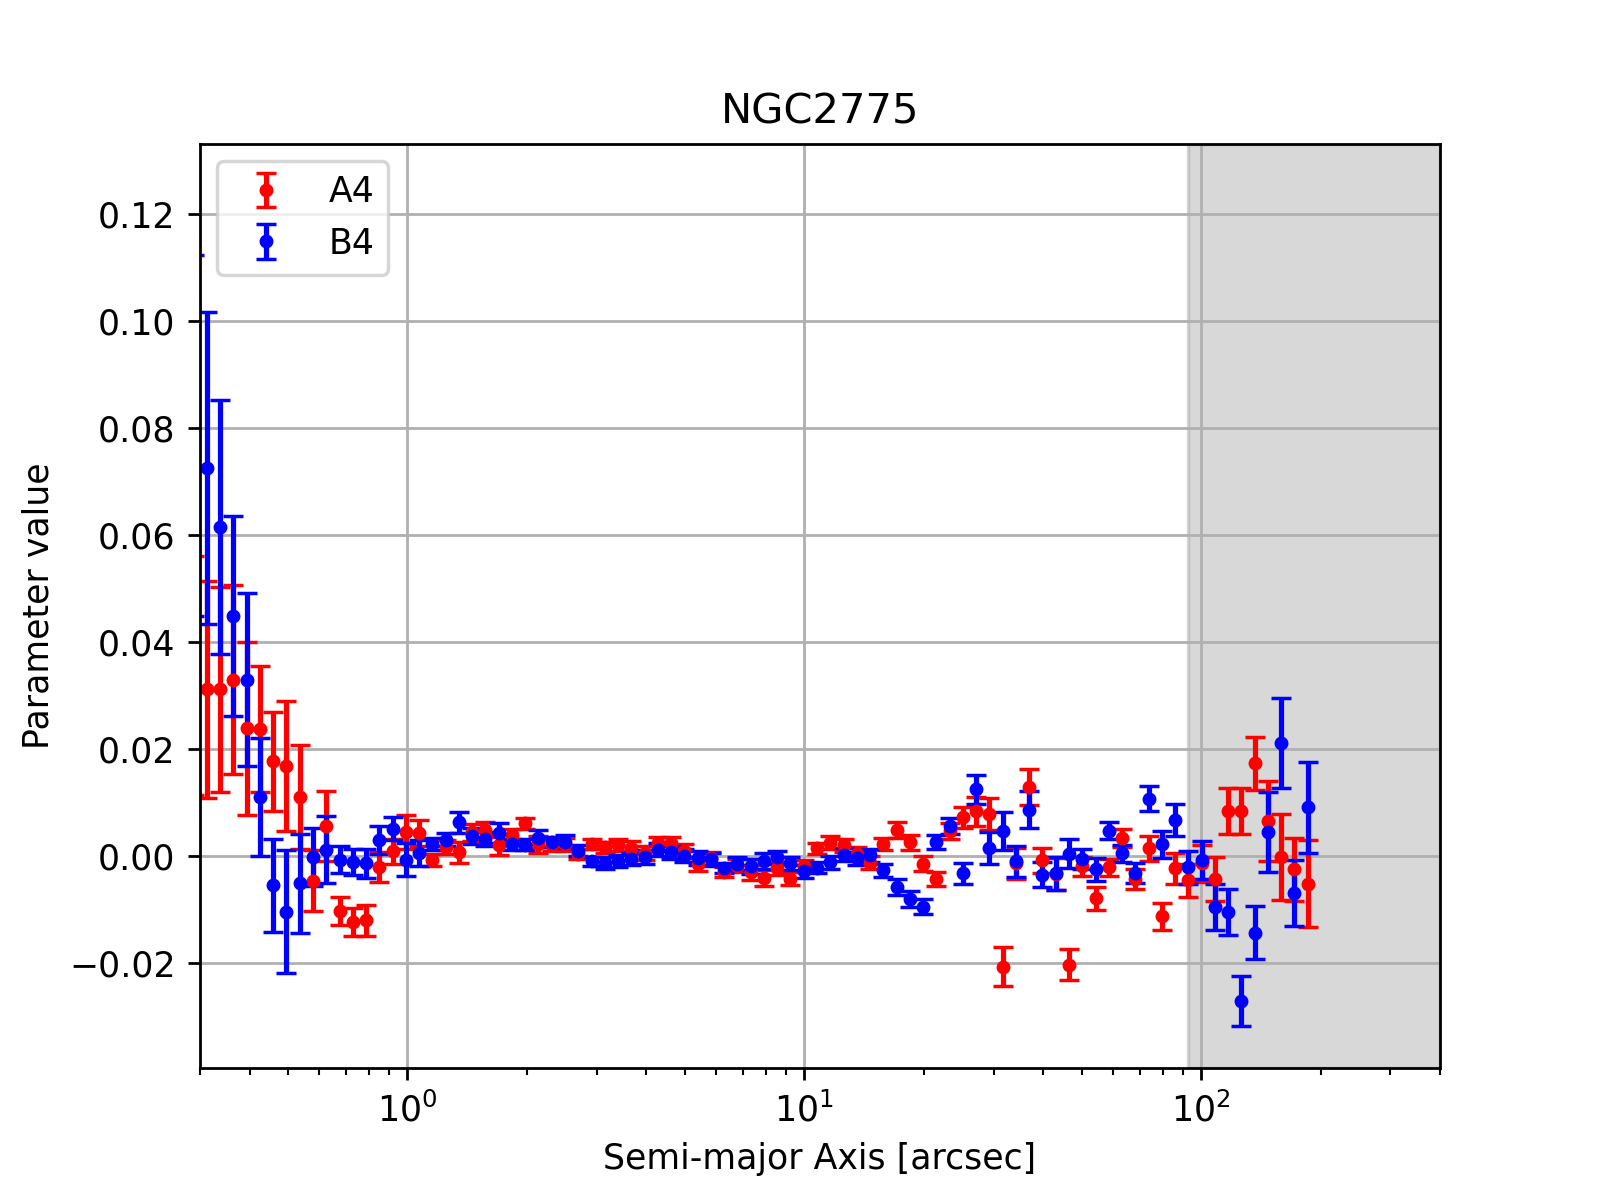

Text(0.5, 0, 'Semi-major Axis [arcsec]')

In [62]:
plt.figure()

ax0 = plt.subplot()
ax0.set_title('NGC2775')
ax0.set_xscale('log')
ax0.errorbar(r_sma_g, iso_df_g['A4'], iso_df_g['A4_ERR'], fmt = '.', c= 'r', capsize = 3, label = 'A4')
ax0.errorbar(r_sma_g, iso_df_g['B4'], iso_df_g['B4_ERR'], fmt = '.', c= 'b', capsize = 3, label = 'B4')
ax0.grid()
ax0.legend()
ax0.set_xlim(0.3, 400)
ax0.axvspan(cut, 400, color = 'gray', alpha = 0.3)
ax0.set_ylabel(r"Parameter value")
ax0.set_xlabel("Semi-major Axis [arcsec]")

<IPython.core.display.Javascript object>


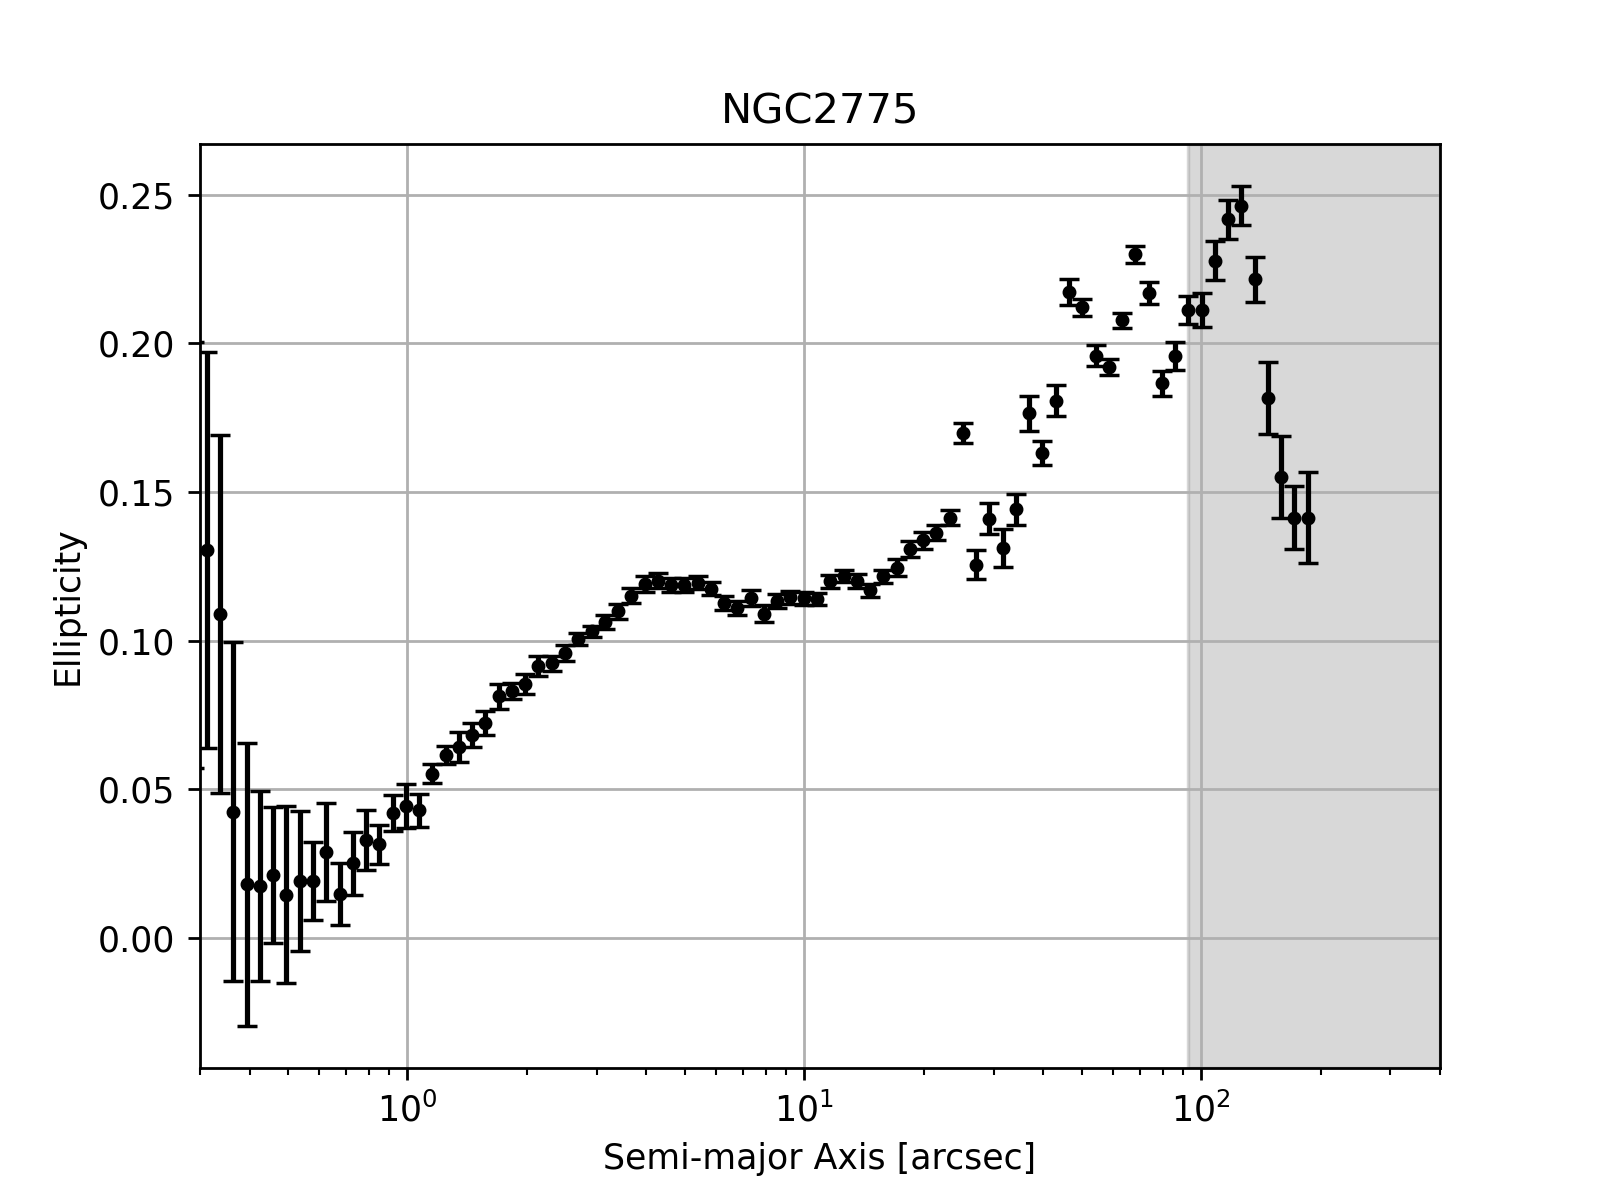

Text(0.5, 0, 'Semi-major Axis [arcsec]')

In [63]:
plt.figure()

ax0 = plt.subplot()
ax0.set_title('NGC2775')
ax0.set_xscale('log')
ax0.errorbar(r_sma_g, iso_df_g['ELLIP'], iso_df_g['ELLIP_ERR'], fmt = '.', c= 'k', capsize = 3)
ax0.grid()
ax0.set_xlim(0.3, 400)
ax0.axvspan(cut, 400, color = 'gray', alpha = 0.3)
ax0.set_ylabel(r"Ellipticity")
ax0.set_xlabel("Semi-major Axis [arcsec]")

### 3) Sersic Profile Fitting

In [28]:
from scipy.optimize import curve_fit

#### Sersic profile (Useful reference: [Graham & Driver 2005](https://ui.adsabs.harvard.edu/abs/2005PASA...22..118G/abstract))

$\large \mu(R)=\mu_{e}+\frac{2.5b_{n}}{\rm ln(10)}\left[(R/R_{e})^{1/n}-1\right]$

where $b_{n}=2n-1/3$

In [29]:
def sersic(r, mu_e, re, n):
    bn = 2 * n - 1/3
    return mu_e + (2.5 * bn / np.log(10)) * ((r / re)**(1/n) - 1)

In [30]:
# Fitting range except r < 1.5 arcsec (Seeing effect)

print("\n*** g-band ***")
popt_g, pcov_g = curve_fit(sersic, r_sma_g[r_sma_g > 1.5], mu_g[r_sma_g > 1.5])
perr_g = np.sqrt(np.diag(pcov_g))
print("Effective radius: {0:.2f} +/- {1:.2f} arcsec".format(popt_g[1], perr_g[1]))
print("Surface brightness at effective radius: {0:.2f} +/- {1:.2f} mag/arcsec^2".format(popt_g[0], perr_g[0]))
print("Sersic index: {0:.2f} +/- {1:.2f}".format(popt_g[2], perr_g[2]))

print("\n*** r-band ***")
popt_r, pcov_r = curve_fit(sersic, r_sma_r[r_sma_r > 1.5], mu_r[r_sma_r > 1.5])
perr_r = np.sqrt(np.diag(pcov_r))
print("Effective radius: {0:.2f} +/- {1:.2f} arcsec".format(popt_r[1], perr_r[1]))
print("Surface brightness at effective radius: {0:.2f} +/- {1:.2f} mag/arcsec^2".format(popt_r[0], perr_r[0]))
print("Sersic index: {0:.2f} +/- {1:.2f}".format(popt_r[2], perr_r[2]))

print("\n*** i-band ***")
popt_i, pcov_i = curve_fit(sersic, r_sma_i[r_sma_i > 1.5], mu_i[r_sma_i > 1.5])
perr_i = np.sqrt(np.diag(pcov_i))
print("Effective radius: {0:.2f} +/- {1:.2f} arcsec".format(popt_i[1], perr_i[1]))
print("Surface brightness at effective radius: {0:.2f} +/- {1:.2f} mag/arcsec^2".format(popt_i[0], perr_i[0]))
print("Sersic index: {0:.2f} +/- {1:.2f}".format(popt_i[2], perr_i[2]))


*** g-band ***
Effective radius: 73.60 +/- 3.83 arcsec
Surface brightness at effective radius: 22.72 +/- 0.11 mag/arcsec^2
Sersic index: 3.88 +/- 0.15

*** r-band ***
Effective radius: 68.71 +/- 3.33 arcsec
Surface brightness at effective radius: 21.82 +/- 0.10 mag/arcsec^2
Sersic index: 3.81 +/- 0.14

*** i-band ***
Effective radius: 71.74 +/- 3.52 arcsec
Surface brightness at effective radius: 21.46 +/- 0.10 mag/arcsec^2
Sersic index: 3.85 +/- 0.14


In [36]:
# Fitting range except r < 1.5 arcsec (Seeing effect)

print("\n*** g-band ***")
popt_g, pcov_g = curve_fit(sersic, r_sma_g[r_sma_g < cut], mu_g[r_sma_g < cut])
perr_g = np.sqrt(np.diag(pcov_g))
print("Effective radius: {0:.2f} +/- {1:.2f} arcsec".format(popt_g[1], perr_g[1]))
print("Surface brightness at effective radius: {0:.2f} +/- {1:.2f} mag/arcsec^2".format(popt_g[0], perr_g[0]))
print("Sersic index: {0:.2f} +/- {1:.2f}".format(popt_g[2], perr_g[2]))

print("\n*** r-band ***")
popt_r, pcov_r = curve_fit(sersic, r_sma_r[r_sma_r < cut], mu_r[r_sma_r < cut])
perr_r = np.sqrt(np.diag(pcov_r))
print("Effective radius: {0:.2f} +/- {1:.2f} arcsec".format(popt_r[1], perr_r[1]))
print("Surface brightness at effective radius: {0:.2f} +/- {1:.2f} mag/arcsec^2".format(popt_r[0], perr_r[0]))
print("Sersic index: {0:.2f} +/- {1:.2f}".format(popt_r[2], perr_r[2]))

print("\n*** i-band ***")
popt_i, pcov_i = curve_fit(sersic, r_sma_i[r_sma_i < cut], mu_i[r_sma_i < cut])
perr_i = np.sqrt(np.diag(pcov_i))
print("Effective radius: {0:.2f} +/- {1:.2f} arcsec".format(popt_i[1], perr_i[1]))
print("Surface brightness at effective radius: {0:.2f} +/- {1:.2f} mag/arcsec^2".format(popt_i[0], perr_i[0]))
print("Sersic index: {0:.2f} +/- {1:.2f}".format(popt_i[2], perr_i[2]))


*** g-band ***
Effective radius: 50.41 +/- 4.59 arcsec
Surface brightness at effective radius: 21.98 +/- 0.16 mag/arcsec^2
Sersic index: 3.19 +/- 0.13

*** r-band ***
Effective radius: 50.52 +/- 4.78 arcsec
Surface brightness at effective radius: 21.21 +/- 0.17 mag/arcsec^2
Sersic index: 3.32 +/- 0.14

*** i-band ***
Effective radius: 51.28 +/- 4.86 arcsec
Surface brightness at effective radius: 20.81 +/- 0.17 mag/arcsec^2
Sersic index: 3.32 +/- 0.14


<IPython.core.display.Javascript object>


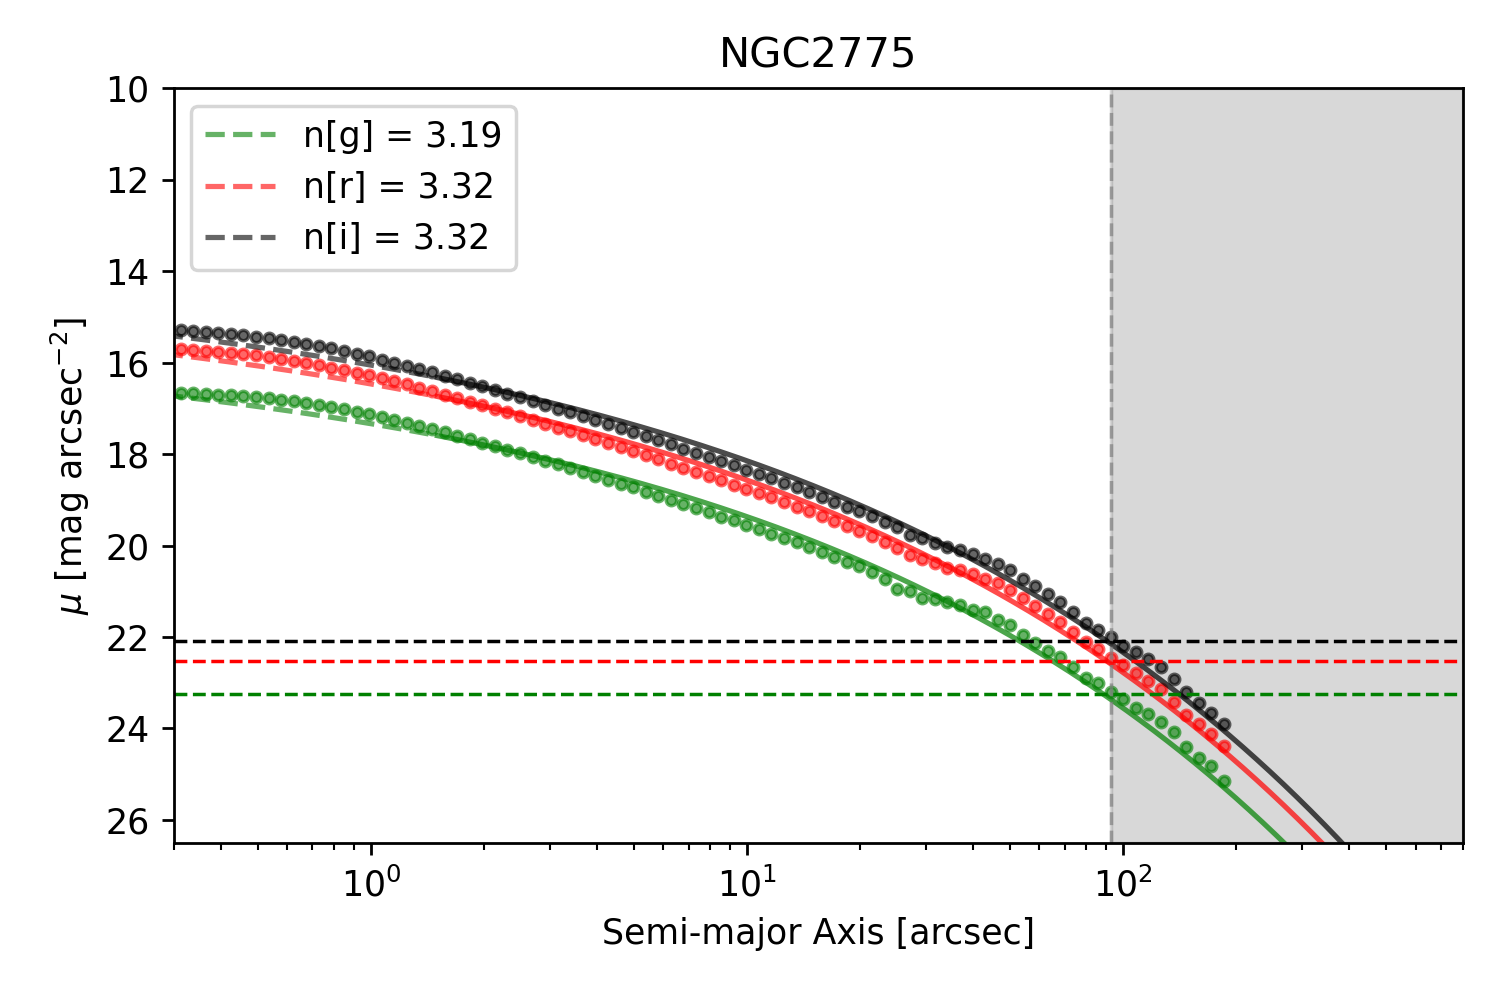

In [39]:
# Plotting for check
r_array = np.logspace(-1.0, 3.0, 1000)

fig, ax = plt.subplots(figsize=(6,4))
plt.title('NGC2775')
ax.plot(r_sma_g, mu_g, 'o', ms=3.0, color='green', alpha=0.6)#, linewidth=2.0, alpha=0.9)
ax.plot(r_array[r_array <= 1.5], sersic(r_array[r_array <= 1.5], *popt_g), '--', color='green', alpha=0.6, label = f'n[g] = {round(popt_g[2],2)}')
ax.plot(r_array[r_array > 1.5] , sersic(r_array[r_array > 1.5], *popt_g) , '-', color='green', alpha=0.7)
ax.plot(r_sma_r, mu_r, 'o', ms=3.0, color='red', alpha=0.6)#, linewidth=2.0, alpha=0.9)
ax.plot(r_array[r_array <= 1.5], sersic(r_array[r_array <= 1.5], *popt_r), '--', color='red', alpha=0.6, label = f'n[r] = {round(popt_r[2],2)}')
ax.plot(r_array[r_array > 1.5] , sersic(r_array[r_array > 1.5], *popt_r) , '-', color='red', alpha=0.7)
ax.plot(r_sma_i, mu_i, 'o', ms=3.0, color='black', alpha=0.6)#, linewidth=2.0, alpha=0.9)
ax.plot(r_array[r_array <= 1.5], sersic(r_array[r_array <= 1.5], *popt_i), '--', color='black', alpha=0.6, label = f'n[i] = {round(popt_i[2],2)}')
ax.plot(r_array[r_array > 1.5] , sersic(r_array[r_array > 1.5], *popt_i) , '-', color='black', alpha=0.7)
ax.legend()

ax.axhline(depth_g, linestyle = '--', linewidth = 1, c = 'g')
ax.axhline(depth_r, linestyle = '--', linewidth = 1, c = 'r')
ax.axhline(depth_i, linestyle = '--', linewidth = 1, c = 'k')
cut = r_sma_g[np.argmin(np.abs(mu_g-depth_g))]
ax.axvspan(cut, 800, color = 'gray', alpha = 0.3)
#ax.axvspan(0.3, 1.5, color = 'gray', alpha = 0.3)
#ax.axvline(1.5, 0, 1, linestyle='--', color='gray', linewidth=1, alpha=0.7)
ax.axvline(cut, 0, 1, linestyle='--', color='gray', linewidth=1, alpha=0.7)
#ax.axvline(popt_g[1], 0, 1, linestyle='-', color='green', linewidth=1.5, alpha=0.5)
#ax.axvline(popt_r[1], 0, 1, linestyle='-', color='red', linewidth=1.5, alpha=0.5)
#ax.axvline(popt_i[1], 0, 1, linestyle='-', color='black', linewidth=1.5, alpha=0.5)
ax.set_xlim([0.3, 800])
ax.set_xscale('log')
ax.set_ylim([26.5, 10])
ax.set_xlabel("Semi-major Axis [arcsec]")
ax.set_ylabel(r"$\mu$ [mag ${\rm arcsec^{-2}}$]")
plt.tight_layout()